In [ ]:


import torch
import numpy as np
import matplotlib.pyplot as plt

import libmoon
from libmoon.solver.gradient.methods import EPOSolver
from libmoon.util.prefs import get_uniform_pref
from libmoon.problem.synthetic.mop import BaseMOP

torch.set_default_dtype(torch.float32)



def abs_smooth(z, eps=1e-8):
    return torch.sqrt(z * z + eps)



class XYssNewton(torch.autograd.Function):
    """
    Forward: batched Newton on z=[x,y] to solve F(z; p)=0
    Backward: uses implicit function theorem
      dz/dp = - (∂F/∂z)^{-1} (∂F/∂p)
    and returns dL/dp = (dL/dz) · (dz/dp).
    """

    @staticmethod
    def forward(ctx, beta_x, beta_y, n, it=60, tol=1e-10, damping=1.0):
        # Shapes: all tensors are (B,)
        B = beta_x.shape[0]
        device = beta_x.device
        eps = 1e-12

        # Initial guess (can be adjusted; ones is robust for many cases)
        x = torch.ones(B, device=device)
        y = torch.ones(B, device=device)

        def F_and_J(x, y, bx, by, nn):
            # F
            y_pow_n = torch.pow(y.clamp_min(eps), nn)
            x_pow_n = torch.pow(x.clamp_min(eps), nn)

            F1 = bx / (1.0 + y_pow_n) - x
            F2 = by * (x_pow_n / (1.0 + x_pow_n)) - y

            # ∂F/∂z
            dF1_dx = -1.0
            dF1_dy = -bx * nn * torch.pow(y.clamp_min(eps), nn - 1.0) / torch.pow(1.0 + y_pow_n, 2.0)
            dF2_dx = by * nn * torch.pow(x.clamp_min(eps), nn - 1.0) / torch.pow(1.0 + x_pow_n, 2.0)
            dF2_dy = -1.0

            A = torch.zeros(B, 2, 2, device=device)
            A[:, 0, 0] = dF1_dx
            A[:, 0, 1] = dF1_dy
            A[:, 1, 0] = dF2_dx
            A[:, 1, 1] = dF2_dy

            F = torch.stack([F1, F2], dim=1)  # (B,2)
            return F, A, x_pow_n, y_pow_n

        for _ in range(int(it)):
            F, A, x_pow_n, y_pow_n = F_and_J(x, y, beta_x, beta_y, n)
            # Solve A * step = F  -> step = A^{-1} F
            step = torch.linalg.solve(A, F.unsqueeze(-1)).squeeze(-1)  # (B,2)
            x_new = x - damping * step[:, 0]
            y_new = y - damping * step[:, 1]

            # Convergence check (∞-norm of step)
            if torch.max(torch.max(torch.abs(step[:, 0]), torch.abs(step[:, 1]))) < tol:
                x, y = x_new, y_new
                break
            x, y = x_new, y_new

        # Save for backward
        ctx.save_for_backward(x, y, beta_x, beta_y, n)
        return torch.stack([x, y], dim=1)  # (B,2)

    @staticmethod
    def backward(ctx, grad_out):
        """
        grad_out: dL/dz with shape (B,2), z=[x,y]
        Return: dL/dbeta_x, dL/dbeta_y, dL/dn, and None for it,tol,damping
        """
        x, y, beta_x, beta_y, n = ctx.saved_tensors
        B = beta_x.shape[0]
        device = beta_x.device
        eps = 1e-12

        # Recompute Jacobians at the solution
        x_cl = x.clamp_min(eps)
        y_cl = y.clamp_min(eps)
        x_pow_n = torch.pow(x_cl, n)
        y_pow_n = torch.pow(y_cl, n)
        ln_x = torch.log(x_cl)
        ln_y = torch.log(y_cl)

        # A = ∂F/∂z
        dF1_dx = -1.0
        dF1_dy = -beta_x * n * torch.pow(y_cl, n - 1.0) / torch.pow(1.0 + y_pow_n, 2.0)
        dF2_dx = beta_y * n * torch.pow(x_cl, n - 1.0) / torch.pow(1.0 + x_pow_n, 2.0)
        dF2_dy = -1.0
        A = torch.zeros(B, 2, 2, device=device)
        A[:, 0, 0] = dF1_dx
        A[:, 0, 1] = dF1_dy
        A[:, 1, 0] = dF2_dx
        A[:, 1, 1] = dF2_dy

        # ∂F/∂p for p = [beta_x, beta_y, n]
        # F1 = beta_x/(1+y^n) - x
        dF1_dbx = 1.0 / (1.0 + y_pow_n)
        dF1_dby = torch.zeros_like(dF1_dbx)
        dF1_dn  = -beta_x * (y_pow_n * ln_y) / torch.pow(1.0 + y_pow_n, 2.0)

        # F2 = beta_y * [ x^n / (1 + x^n) ] - y
        dF2_dbx = torch.zeros_like(dF1_dbx)
        dF2_dby = x_pow_n / (1.0 + x_pow_n)
        dF2_dn  = beta_y * (x_pow_n * ln_x) / torch.pow(1.0 + x_pow_n, 2.0)

        Bmat = torch.zeros(B, 2, 3, device=device)
        Bmat[:, 0, 0] = dF1_dbx
        Bmat[:, 0, 1] = dF1_dby
        Bmat[:, 0, 2] = dF1_dn
        Bmat[:, 1, 0] = dF2_dbx
        Bmat[:, 1, 1] = dF2_dby
        Bmat[:, 1, 2] = dF2_dn

        # dz/dp = - A^{-1} * B
        rhs = -Bmat  # (B,2,3)
        dzdp = torch.linalg.solve(A, rhs)  # (B,2,3)

        # dL/dp = (dL/dz)^T * dz/dp
        # grad_out: (B,2); dzdp: (B,2,3) -> (B,3)
        grad_p = torch.einsum('bi,bij->bj', grad_out, dzdp)

        d_bx = grad_p[:, 0]
        d_by = grad_p[:, 1]
        d_n  = grad_p[:, 2]
        return d_bx, d_by, d_n, None, None, None



def S_betax_xss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = beta_x * (1 + xcl.pow(n)) * (1 + ycl.pow(n))
    den = (n**2) * beta_x * ycl.pow(n) + xcl * (1 + ycl.pow(n)).pow(2) + xcl.pow(1 + n) * (1 + ycl.pow(n)).pow(2)
    return abs_smooth(num / (den + eps))

def S_betax_yss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = n * beta_x * beta_y * xcl.pow(n - 1)
    den = (1 + xcl.pow(n)).pow(2) * ycl + (n**2) * beta_y * xcl.pow(n) * ycl.pow(n) + (1 + xcl.pow(n)).pow(2) * ycl.pow(1 + n)
    return abs_smooth(num / (den + eps))

def S_betay_xss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = n * beta_x * (1 + xcl.pow(n)) * ycl.pow(n)
    den = (n**2) * beta_x * ycl.pow(n) + xcl * (1 + ycl.pow(n)).pow(2) + xcl.pow(1 + n) * (1 + ycl.pow(n)).pow(2)
    return abs_smooth((-num) / (den + eps))

def S_betay_yss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    num = beta_x * beta_y * xcl.pow(n - 1) * (1 + xcl.pow(n))
    den = (1 + xcl.pow(n)).pow(2) * ycl + (n**2) * beta_y * xcl.pow(n) * ycl.pow(n) + (1 + xcl.pow(n)).pow(2) * ycl.pow(1 + n)
    return abs_smooth(num / (den + eps))

def S_n_xss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    ln_x, ln_y = torch.log(xcl), torch.log(ycl)
    num = n * beta_x * (n * ln_x + ln_y + ln_y * xcl.pow(n)) * ycl.pow(n)
    den = (n**2) * beta_x * ycl.pow(n) + xcl * (1 + ycl.pow(n)).pow(2) + xcl.pow(1 + n) * (1 + ycl.pow(n)).pow(2)
    return abs_smooth((-num) / (den + eps))

def S_n_yss(x, y, beta_x, beta_y, n, eps=1e-12):
    xcl, ycl = x.clamp_min(eps), y.clamp_min(eps)
    ln_x, ln_y = torch.log(xcl), torch.log(ycl)
    num = n * beta_y * xcl.pow(n) * (ln_x + (ln_x - n * ln_y) * ycl.pow(n))
    den = (1 + xcl.pow(n)).pow(2) * ycl + (n**2) * beta_y * xcl.pow(n) * ycl.pow(n) + (1 + xcl.pow(n)).pow(2) * ycl.pow(1 + n)
    return abs_smooth(num / (den + eps))


OBJECTIVES = {
    "S_betax_xss": S_betax_xss,
    "S_betax_yss": S_betax_yss,
    "S_betay_xss": S_betay_xss,
    "S_betay_yss": S_betay_yss,
    "S_n_xss":     S_n_xss,
    "S_n_yss":     S_n_yss,
}


SELECTED_OBJECTIVES = ("S_betax_xss", "S_betax_yss")


# ---------------------------
# Multi-objective problem
# ---------------------------
class Sensitivity2D_MOP(BaseMOP):
    """
    Decision vars: z = [beta_x, beta_y, n]
      beta_x ∈ [1e-4, 100], beta_y ∈ [1e-4, 100], n ∈ [0.2, 8]
    Objectives: any two from OBJECTIVES
    """
    def __init__(self, obj_names=SELECTED_OBJECTIVES, eps=1e-8):
        super().__init__(n_var=3, n_obj=2, n_cons=0)
        self.obj_names = obj_names
        self.obj_funcs = [OBJECTIVES[nm] for nm in obj_names]
        self.problem_name = "ZDT1"
        self.lbound = torch.tensor([1e-4, 1e-4, 0.2])
        self.ubound = torch.tensor([1e2 , 1e2 , 8.0])
        self.eps = float(eps)

    def _evaluate_torch(self, z):
        lb = self.lbound.to(z.device)
        ub = self.ubound.to(z.device)
        beta_x = z[:, 0].clamp(lb[0], ub[0])
        beta_y = z[:, 1].clamp(lb[1], ub[1])
        n      = z[:, 2].clamp(lb[2], ub[2])

        # Steady state (x_ss, y_ss) with implicit gradients
        xy = XYssNewton.apply(beta_x, beta_y, n)  # (B,2)
        x, y = xy[:, 0], xy[:, 1]

        # Two objectives
        f1 = self.obj_funcs[0](x, y, beta_x, beta_y, n)
        f2 = self.obj_funcs[1](x, y, beta_x, beta_y, n)

        return torch.stack([f1, f2], dim=1)



In [ ]:


problem = Sensitivity2D_MOP(obj_names=SELECTED_OBJECTIVES, eps=1e-8)

K = 1000
prefs = get_uniform_pref(K, 2, clip_eps=1e-2)

lb, ub = problem.lbound, problem.ubound
x0 = lb + torch.rand(K, 3) * (ub - lb)  # random init over the box

solver = EPOSolver(
    step_size=1e-1,
    n_epoch=100,
    tol=1e-6,
    problem=problem,
    prefs=prefs
)

res = solver.solve(x_init=x0)


100%|██████████| 100/100 [09:08<00:00,  5.49s/it]


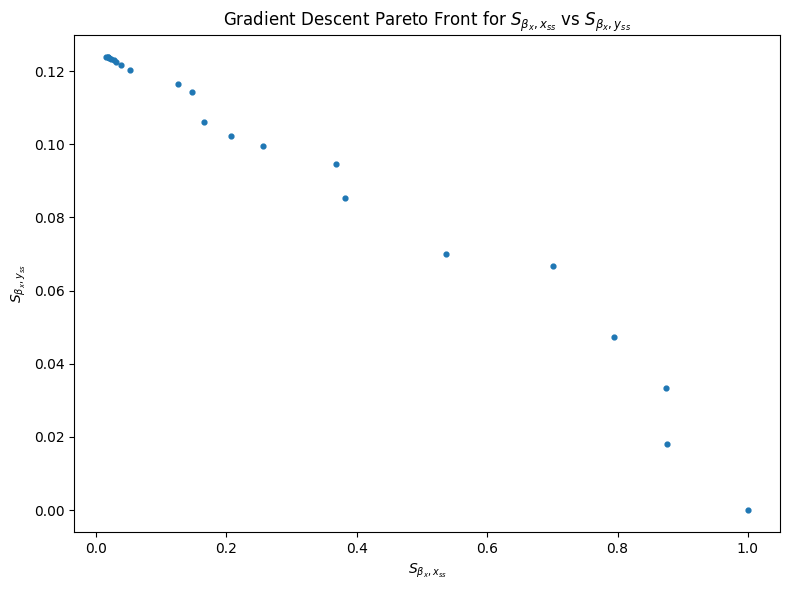

In [4]:

X = res["x"]  # (K,3) : (beta_x, beta_y, n)
Y = res["y"]  # (K,2) : (f1, f2)

import numpy as np
from paretoset import paretoset

# 'paretoset' expects a matrix of costs. Since we want to minimize both objectives, we can use Y directly.
# The second argument ['min', 'min'] specifies we are minimizing both columns.
mask = paretoset(Y, sense=['min', 'min'])

Y_pf_paretoset = Y[mask]

# Plot
plt.figure(figsize=(8,6))
plt.scatter(Y_pf_paretoset[:, 0], Y_pf_paretoset[:, 1], s=12)
plt.xlabel(r'$S_{\beta_x,x_{ss}}$')  # Sensitivity of xss to beta_x
plt.ylabel(r'$S_{\beta_x,y_{ss}}$')  # Sensitivity of yss to beta_x
plt.title(r'Gradient Descent Pareto Front for $S_{\beta_x,x_{ss}}$ vs $S_{\beta_x,y_{ss}}$')
plt.tight_layout()
plt.show()
